<!DOCTYPE html>
<html>
    <body>
        <h3>Descriptions of files:</h3>
        <ol>
            <li>Stores.csv: Contains the anonyised information aout the 45 stores, indicating the type and size of store</li>
            <li>Train.csv: This is the historical training sata which covers to 2010-02-05 TO 2012-11-01. Within this file you will find the following fields:</li>
            <ul>
                <li>Store- The store number</li>
                <li>Dept - THE Department Number</li>
                <li>Date - The week</li>
                <li>Weekly Sales - Sales for the given department in the given store</li>
                <li>IsHoliday - Whether the week is a special holiday week</li>
            </ul>
            <li>Test.csv - This is identical to the train.csv except the weekly sales have been witheld</li>
            <li>features.csv- The file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields</li>
                <ul>
                    <li>Store- The store number</li>
                    <li>Date - The week</li>
                    <li>Temperature - Average temperature in the region</li>
                    <li>Fuel_Price - Cost of fuel in the region</li>
                    <li>Markdown1-5 - Anonymised data related to promotional markdowns that Walmart is running. Markdown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA</li>
                    <li>CPI - the consumer price index</li>
                    <li>Unemployment - The unemployment rate</li>
                    <li>IsHoliday - Whether the week is a special holiday week</li>
                </ul>
        </ol>
<p>For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):</p>
<ul>
    <li>SuperBowl: 12-02-2010, 11-02-2011, 10-02-2012, 8-02-2013</li>
    <li>Labour Day: 10-09-2010, 9-09-2011, 7-09-2012, 6-09-2013,</li>
    <li>Thanksgiving: 26-11-2010, 25-11-2011, 23-11-2012, 20-11-2013</li>
    <li>Christmas: 31-12-2010, 30-12-2011, 28-12-2012, 27-12-2013</li>
</ul>

<hr>
<p>
<b>Evaluation Metric:</b> Weighted Mean Absolute Error (WMAE)
    <b><pre style = 'text-align:center'>1/sum(wi) * sum(wi|yi - ^y|)</pre></b>
where wi are weights, w=5 if the week is a holiday week, 1 otherwise.
</p>
</body>
</html>

In [1]:
path = "C:/Machine_learning_datafiles/kaggle/Walmart_recruiting_store_sales"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scipy_stats
import missingno as msno

In [116]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold,TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import catboost as cat
import lightgbm as lgb
import category_encoders as cat_encoders
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
os.chdir(path)

In [6]:
os.listdir()

['catboost_info',
 'features.csv',
 'predictions',
 'Readme.txt',
 'sampleSubmission.csv',
 'stores.csv',
 'test.csv',
 'Test_cleaned.pkl',
 'train.csv',
 'Train_cleaned.pkl']

In [7]:
train = pd.read_pickle('Train_cleaned.pkl', compression='zip')
test = pd.read_pickle('Test_cleaned.pkl', compression='zip')
subfile = pd.read_csv('sampleSubmission.csv')

In [89]:
pd.set_option("display.max_columns", 100)
plt.style.use('classic')
%matplotlib inline

In [10]:
seed = 42
np.random.seed(seed)

In [11]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,week,month,year,Season
0,1,1,2010-02-05,24924.50,0,3,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,2,2010,3
1,1,1,2010-02-12,46039.49,1,3,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,6,2,2010,3
2,1,1,2010-02-19,41595.55,0,3,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,7,2,2010,3
3,1,1,2010-02-26,19403.54,0,3,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,8,2,2010,3
4,1,1,2010-03-05,21827.90,0,3,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,9,3,2010,1


In [12]:
test.head(3)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,week,month,year,Season
0,1,1,2012-11-02,0,3,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,44,11,2012,0
1,1,1,2012-11-09,0,3,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,45,11,2012,0
2,1,1,2012-11-16,0,3,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,46,11,2012,0


In [73]:
train.Weekly_Sales

0         24924.50
1         46039.49
2         41595.55
3         19403.54
4         21827.90
            ...   
421565      508.37
421566      628.10
421567     1061.02
421568      760.01
421569     1076.80
Name: Weekly_Sales, Length: 421570, dtype: float64

In [88]:
(train.Weekly_Sales**(1/4)).max()

28.853524767162636

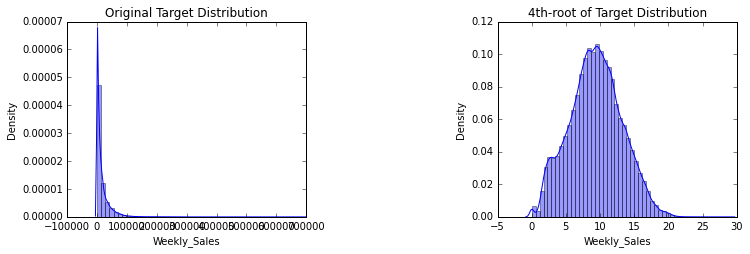

In [90]:
plt.figure(figsize=(12,3.5))
plt.subplot(121)
sns.distplot(train.Weekly_Sales)
plt.title('Original Target Distribution')
plt.subplot(122)
sns.distplot((train.Weekly_Sales**(1/4)))
plt.title('4th-root of Target Distribution')
plt.subplots_adjust(wspace=0.8);

`For categorical features with cardinality more than 10 unique values We will use target encoding, and one-hot encoding, if otherwise.`

`Because this is a time series data, we will randomly split the data, so we will split at a date before a certain date and predict on date after it.`

In [100]:
def linearData(data, cat_cols:list, target_cols:list):
    if (not isinstance(cat_cols, (list, tuple,str)) or not isinstance(target_cols, (list, tuple,str))):
        raise TypeError 
    data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
    xtest = pd.get_dummies(test, columns=cat_cols, drop_first=True)
    
    cat_enc = cat_encoders.TargetEncoder(cols=target_cols, smoothing=50)
    train_ = data[data.Date < '2012-03-01']
    val_ =  data[data.Date >= '2012-03-01']
    
    xtrain, ytrain = train_.drop('Weekly_Sales', 1), train_.Weekly_Sales
    xval, yval = val_.drop('Weekly_Sales', 1), val_.Weekly_Sales
    
    cat_enc.fit(xtrain, ytrain**(1/4))
    xtrain = cat_enc.transform(xtrain)
    xval =  cat_enc.transform(xval)
    xtest = cat_enc.transform(xtest)
    return xtrain, xval, ytrain, yval, xtest

In [14]:
def datasplit(data):
    train_ = data[data.Date < '2012-03-01']
    val_ =  data[data.Date >= '2012-03-01']
    xtrain, ytrain = train_.drop('Weekly_Sales', 1), train_.Weekly_Sales
    xval, yval = val_.drop('Weekly_Sales', 1), val_.Weekly_Sales
    return xtrain, xval, ytrain, yval

In [16]:
xtrain, xval, ytrain, yval = datasplit(train)

In [101]:
xtrain_lin, xval_lin, ytrain_lin, yval_lin, xtest_lin = linearData(train, cat_cols=['Season', 'Type'], 
                                                                   target_cols=['Store', 'Dept'])

In [106]:
xtrain_lin.shape, xval_lin.shape, xtrain.shape, xval.shape

((317928, 22), (103642, 22), (317928, 19), (103642, 19))

In [19]:
def WMAE_Score(dataset, Actual, predicted):
    """
    Calculates the Weighted mean absolute error metric of the model
    :params  dataset: dataset
    :params Actual: Actual values
    :params predicted: Predicted values
    :returns the Weighted Mean Absolute Error (WMAE)
    """
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
#     wmae = np.sum(weights * abs(Actual - predicted)) / (np.sum(weights)) #similar down
    wmae = mean_absolute_error(Actual, predicted, sample_weight=weights)
    return wmae

In [99]:
def train_model(model, xtr, xvl, ytr, yvl):
    xtr = xtr.drop(['Date'], 1)
    xvl = xvl.drop(['Date'], 1)
    ytr = ytr**(1/4)
    yvl = yvl**(1/4)
    
    if model.__class__.__name__ in ['CatBoostRegressor', 'LGBMRegressor']:
        model.fit(xtr, ytr, eval_set=[(xvl, yvl)], early_stopping_rounds=250, verbose=False)
    else:
        model.fit(xtr, ytr)
    
    preds = model.predict(xvl)**4 #converting to original using the inverse
    
    tr_weights = xtr.IsHoliday.apply(lambda x: 5 if x else 1)
    val_weights = xvl.IsHoliday.apply(lambda x: 5 if x else 1)
    
    tr_rmse = mean_squared_error(ytr**4, model.predict(xtr)**4, squared=False, sample_weight=tr_weights)
    tr_mae = mean_absolute_error(ytr**4, model.predict(xtr)**4, sample_weight=tr_weights)
    
    val_rmse = mean_squared_error(yvl**4, preds, squared=False, sample_weight=val_weights)
    val_mae = mean_absolute_error(yvl**4, preds, sample_weight=val_weights)
    print('Train WRMSE: {:.4f} Train WMAE: {:.4f}'.format(tr_rmse, tr_mae))
    print('Val WRMSE: {:.4f} Val WMAE: {:.4f}'.format(val_rmse, val_mae))
    return model

In [93]:
num_cols = xtrain_lin.columns.drop(['Season_1', 'Season_2', 'Season_3', 'Type_2',
                                    'Type_3', 'Date'])
dont = ['Season_1', 'Season_2', 'Season_3', 'Type_2', 'Type_3']

In [94]:
scaler = StandardScaler()
coltrans = ColumnTransformer([
    ('scale', scaler, num_cols),
    ('no_scale', 'passthrough', dont)], n_jobs=-1)

In [95]:
ridge = Ridge(random_state=seed, alpha=1500, solver='saga')

rf = RandomForestRegressor(random_state=seed, min_samples_leaf=7, min_samples_split=5, 
                           max_features=0.4, n_jobs=-1, n_estimators=600, max_samples=0.7)

catm = cat.CatBoostRegressor(random_seed=seed, n_estimators=6000, bootstrap_type='Bernoulli', 
                             subsample=0.7, rsm=0.7, silent=True, learning_rate=0.1)

lgbm  = lgb.LGBMRegressor(random_state=seed, n_estimators=5000, learning_rate=0.06, reg_lambda=3, 
                          importance_type='gain', subsample=0.7, colsample_bytree=0.6)

In [96]:
ridge_pl = Pipeline([('col_trans', coltrans), ('ridge', ridge)])

**`TRAINING`**

In [107]:
train_model(ridge_pl, xtrain_lin, xval_lin, ytrain_lin, yval_lin);

Train WRMSE: 14461.9536 Train WMAE: 6429.7367
Val WRMSE: 11176.0719 Val WMAE: 5925.2691


In [111]:
train_model(rf, xtrain, xval, ytrain, yval);

Train WRMSE: 10607.5466 Train WMAE: 3987.2793
Val WRMSE: 8617.8684 Val WMAE: 4361.9955


In [112]:
train_model(lgbm, xtrain, xval, ytrain, yval);

Train WRMSE: 3728.3008 Train WMAE: 1470.4683
Val WRMSE: 4461.1244 Val WMAE: 2162.4851


In [115]:
train_model(catm, xtrain, xval, ytrain, yval);

Train WRMSE: 4736.9073 Train WMAE: 1815.7372
Val WRMSE: 4646.8125 Val WMAE: 2313.4573


In [148]:
lgbm.best_iteration_, catm.best_iteration_

(5000, 5997)

In [119]:
def plotImportance(model):
    if model.__class__.__name__ == 'Ridge':
        pd.Series(model.coef_, index=xtrain_lin.columns.drop(['Date'])).sort_values().plot.barh(
            title=model.__class__.__name__)
    else:
        pd.Series(model.feature_importances_, index=xtrain.columns.drop(['Date'])).sort_values().plot.barh(
            title=model.__class__.__name__)

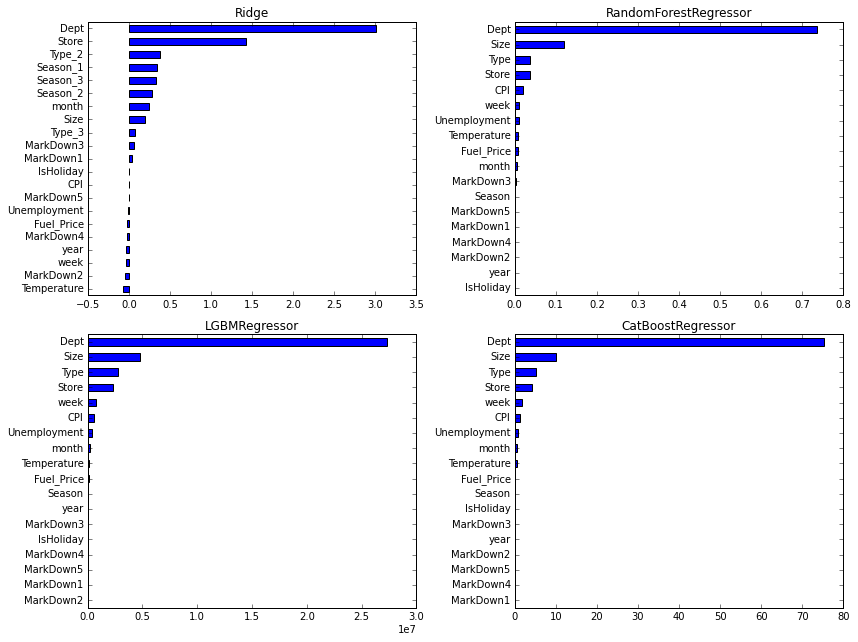

In [120]:
plt.figure(figsize=(12,9))
for i, model in enumerate([ridge, rf,lgbm, catm]):
    plt.subplot(2,2,i+1)
    plotImportance(model)
plt.tight_layout(pad=1.)

In [165]:
def FinalPreds(model, X, y, test_set):
    X = X.drop('Date', 1)
    test_c = test_set.drop('Date', 1)
    model.fit(X, y**(1/4))
    preds = model.predict(test_c)**4
    return preds

**PREDICTIONS**

In [163]:
xtest_lin.shape, X_lin.shape

((115064, 22), (421570, 22))

In [156]:
X_lin = pd.concat([xtrain_lin, xval_lin], axis=0)
X = pd.concat([xtrain, xval], axis=0)
y_lin = pd.concat([ytrain_lin, yval_lin], axis=0)
y = pd.concat([ytrain, yval], axis=0)

In [166]:
ridge_pred = FinalPreds(ridge_pl, X_lin, y_lin, xtest_lin)

In [176]:
rf.n_estimators = 1000 #increasing number of trees
rf_pred = FinalPreds(rf, X, y, test)

In [183]:
lgbm.n_estimators = 6500
lgb_pred = FinalPreds(lgbm, X, y, test)

In [194]:
catm.n_estimators = 7500
cat_pred = FinalPreds(catm, X, y, test)

In [213]:
gc.collect()

3502279

In [214]:
wt_av = cat_pred * 0.3 + lgb_pred * 0.7

In [215]:
scores = pd.DataFrame(np.c_[ridge_pred, rf_pred, lgb_pred, cat_pred, wt_av], 
                      columns=['RIDGE', 'RF', 'LGB', 'CAT', 'WT_VOTING'])
scores

,RIDGE,RF,LGB,CAT,WT_VOTING
0,23427.337843,24807.997799,34004.789473,36000.719904,34603.568602
1,23540.548091,22436.707621,19580.275847,19171.289089,19457.579820
2,24050.362941,22129.254778,19274.504024,18953.246942,19178.126900
3,29699.626704,25391.657073,19122.032766,18420.680309,18911.627029
4,24072.818797,24976.135342,23457.201901,20313.639362,22514.133139
...,...,...,...,...,...
115059,2879.744890,802.643099,698.272118,778.018664,722.196082
115060,2983.631907,883.579463,857.337052,897.478213,869.379400
115061,2969.145125,841.465384,622.153133,726.825939,653.554975
115062,2927.321298,848.896893,584.547213,756.583197,636.158008


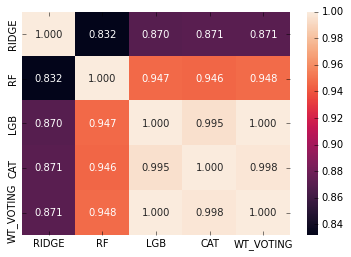

In [216]:
sns.heatmap(scores.corr(), annot=True, fmt='.3f');

**Submission**

In [200]:
ridge_df = subfile.copy()
ridge_df['Weekly_Sales'] = ridge_pred.astype('float32')

In [201]:
rf_df = subfile.copy()
rf_df['Weekly_Sales'] = rf_pred.astype('float32')

In [202]:
lgb_df = subfile.copy()
lgb_df['Weekly_Sales'] = lgb_pred.astype('float32')

In [203]:
cat_df = subfile.copy()
cat_df['Weekly_Sales'] = cat_pred.astype('float32')

In [217]:
voting_df = subfile.copy()
voting_df['Weekly_Sales'] = wt_av.astype('float32')

In [219]:
ridge_df.to_csv(os.path.join(path, 'predictions/ridge_bl.csv'), index=False)
rf_df.to_csv(os.path.join(path, 'predictions/rf_bl.csv'), index=False)
lgb_df.to_csv(os.path.join(path, 'predictions/lgb_bl.csv'), index=False)
cat_df.to_csv(os.path.join(path, 'predictions/cat_bl.csv'), index=False)
voting_df.to_csv(os.path.join(path, 'predictions/voting_bl.csv'), index=False)

In [220]:
gc.collect()

7459